In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
cwd = os.getcwd()
root_dir = os.path.abspath(os.path.join(cwd, os.pardir))
root_dir

'/home/egianuzzi/Documentos/git/AstroBould'

In [3]:
def read_sump(sump_name="sump.out"):
    full_name = os.path.join(root_dir, sump_name)
    if not os.path.isfile(full_name):
        print("El archivo %s no existe"%os.path.basename(full_name))
        return
    df = pd.read_csv(full_name, delimiter='\s+', header=None,
                      names=["idx",
                             "bad",
                             "t_t",
                             "L_t", # Total
                             "mass", # Particle
                             "a_i", "e_i", "M_i", "omega_i", "R_i",
                             "l_i",
                             "t_f",
                             "a_f", "e_f", "M_f", "omega_f", "R_f",
                             "l_f",
                             "amin", "amax", 
                             "emin", "emax", 
                             "da", "de"])
    if df.idx.nunique() == 1:
        df.idx = range(0,len(df))
    return df

def read_outfile(name, nboulders=2, coord=False):
    full_name = os.path.join(root_dir, name)
    if not os.path.isfile(full_name):
        print("El archivo %s no existe"%os.path.basename(full_name))
        return
    if coord:
        df = pd.read_csv(name, delimiter='\s+', header=None,
                         names=["idx",
                                "t",
                                "x", "y",
                                "vx", "vy",
                                "ax", "ay",
                                "mass", "radio"])
        df.name = name.split(".")[0]
        df.nt = df.idx.nunique()
        df.nb = nboulders
        df.np = df.nt - nboulders
        df["r"] = np.sqrt(df["x"]**2 + df["y"]**2)
        df["v"] = np.sqrt(df["vx"]**2 + df["vy"]**2)
        df["a"] = np.sqrt(df["ax"]**2 + df["ay"]**2)
    else:
        df = pd.read_csv(name, delimiter='\s+', header=None,
                         names=["idx",
                                "t",
                                "a", "e", "M", "omega", "MMR",
                                "mass", # Particle
                                "acorot", # To Be Changed with Particle_distance
                                "spin", "mast"]) # Asteroid
        df.name = name.split(".")[0]
        df["lorb"] = np.sqrt(df.a * (1 - df.e**2))
        df.da = df.a.max() - df.a.min()
        df.de = df.e.max() - df.e.min()
        df.tmax = df.t.iloc[-1]
    return df

def read_map(name):
    full_name = os.path.join(root_dir, name)
    if not os.path.isfile(full_name):
        print("El archivo %s no existe"%os.path.basename(full_name))
        return
    df = pd.read_csv(full_name, delimiter='\s+', header=None,
                     names=["x", "y", "pot", "ax", "ay"])
    df["r"] = np.sqrt(df["x"]**2 + df["y"]**2)
    df["acc"] = np.sqrt(df["ax"]**2 + df["ay"]**2)
    return df

get_MMR = lambda a: (a/2.130962668815482E+02)**(3/2)
get_a = lambda R: R**(2/3.) * 2.130962668815482E+02

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:64: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_38897/448087537.py:6: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(full_name, delimiter='\s+', header=None,
/tmp/ipykernel_38897/448087537.py:30: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(name, delimiter='\s+', header=None,
/tmp/ipykernel_38897/448087537.py:45: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(name, delimiter='\s+', header=None,
/tmp/ipykernel_38897/448087537.py:64: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(full_name, delimiter='\s+', header=None,


In [4]:
sump = read_sump()
sump

El archivo sump.out no existe


In [5]:
if sump is not None:
    bad = sump.bad > 0
    plt.figure(dpi=150)
    plt.suptitle("$t_{max} = %d$ yrs"%int(sump.t_t.max()/365.25))
    plt.plot(sump.R_i[bad], sump.R_f[bad], ".", label="Colision")
    plt.plot(sump.R_i[~bad], sump.R_f[~bad], ".", label="Survived")
    plt.xlabel("Initial RMM")
    plt.ylabel("Final RMM")
    plt.legend()
    plt.show()

In [6]:
file_list = []
pref = "dpy"
suffix = ""
# Recorre todas las subcarpetas en la carpeta raíz
for subdir in os.listdir(root_dir):
    # Verifica si el nombre de la subcarpeta comienza con 'pref'
    if subdir.startswith(pref):
        subdir_path = os.path.join(root_dir, subdir)
        # Recorre todos los archivos en la subcarpeta
        for filename in os.listdir(subdir_path):
            # Verifica si el nombre del archivo comienza con
            # "chaos" y termina con ".dat"
            if (filename.startswith("salida")
                and filename.endswith(".dat")
                and (suffix in filename)
            ):
                filepath = os.path.join(subdir_path, filename)
                file_list.append(filepath)

# Ordena los nombres de los archivos por el valor de i en "chaos%d%s.dat"
if suffix == "":
    file_list = sorted(
        file_list, key=lambda x: int(x.split("salida")[1].split(".dat")[0])
    )
else:
    file_list = sorted(
        file_list,
        key=lambda x: int(
            x.split("salida")[1].split(".dat")[0].split(suffix)[0]
        ),
    )

In [7]:
dfs = dict()
for salida in file_list:
    number = os.path.basename(salida)[6:].split(".")[0]
    df = read_outfile(salida, coord=False)
    dfs[int(number)] = df    

In [8]:
if dfs:
    plt.figure(dpi=200)
    plt.suptitle("Drag coefficient: %.3f"%1e-2)
    for idf in dfs:
        plt.plot(dfs[idf].t/365.25, dfs[idf].e, "k-", lw=0.6, ms=0.2, alpha=idf/120)
    plt.xlabel("Years")
    plt.ylabel("$e$")
    plt.semilogx()
    plt.semilogy()
    plt.show()

In [9]:
if dfs:
    plt.figure(dpi=170)
    plt.suptitle("Drag coefficient: %.3f"%1e-2)
    for idf in dfs:
        plt.plot(dfs[idf].t/365.25, (dfs[idf].lorb - dfs[idf].lorb.iloc[0])/dfs[idf].lorb.iloc[0], "k.", lw=0.6, ms=0.2)
    plt.xlabel("Years")
    plt.ylabel("$\\Delta L_{part}/L_{part}(t=0)$")
    plt.grid()
    plt.semilogx()
    plt.xticks([10**x for x in range(-2,7)])
    plt.show()

In [10]:
if dfs:
    G = 4.9823394e-10 
    m0 = 6.3e18
    R0 = 129.
    mD = m0 * 1e1
    mp = mD / len(dfs)
    mu = G * m0 * mp
    I = 4.204006931643356E+22
    Last = 7.575367962011342E+23
    omegai = 1.801939931400187E+01

In [11]:
if dfs:
    plt.figure(dpi=150)
    for i in range(len(dfs)-2):
        Lparti = np.sqrt(mu) * dfs[i].lorb.iloc[0]
        dfs[i].Ltot = Last + Lparti
        plt.plot(dfs[i].a.iloc[0], Lparti / dfs[i].Ltot, "k.")
        Lpartf = np.sqrt(mu) * dfs[i].lorb.iloc[-1]
        plt.plot(dfs[i].a.iloc[0], Lpartf / dfs[i].Ltot, "r.")
    i = len(dfs)-1
    Lparti = np.sqrt(mu) * dfs[i].lorb.iloc[0]
    dfs[i].Ltot = Last + Lparti
    plt.plot(dfs[i].a.iloc[0], Lparti / dfs[i].Ltot, "k.", label="Initial")
    Lpartf = np.sqrt(mu) * dfs[i].lorb.iloc[-1]
    plt.plot(dfs[i].a.iloc[0], Lpartf / dfs[i].Ltot, "r.", label="Final")
    plt.legend()
    plt.ylabel("$L_{part}/L_{tot}$")
    plt.xlabel("Initial $a$ [km]")
    plt.show()

In [12]:
if dfs:
    plt.figure(dpi=170)
    for i in dfs:
        df = dfs[i]
        Li = df.lorb.iloc[0]
        Lf = df.lorb.iloc[-1]
        plt.plot(df.tmax/365.25, np.sqrt(mu) * (Lf - Li) / I, "k.")
    plt.xlabel("tmax [years]")
    plt.ylabel("$\Delta a$ [km]")
    plt.ylabel("$\Delta \Omega$")
    plt.semilogx()
    # plt.semilogy()
    plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_37979/673943490.py:9: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta a$ [km]")
/tmp/ipykernel_37979/673943490.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta \Omega$")


In [13]:
if dfs:
    plt.figure(dpi=170)
    for i in dfs:
        df = dfs[i]
        Li = df.lorb.iloc[0]
        Lf = df.lorb.iloc[-1]
        delta_omega = np.sqrt(mu) * (Lf - Li) / I
        omegaf = omegai + delta_omega
        plt.plot(df.tmax/365.25, 2 * np.pi * (1/omegaf - 1/omegai), "k.")
    plt.xlabel("tmax [years]")
    plt.ylabel("$\Delta a$ [km]")
    plt.ylabel("$\Delta$ P [days]")
    plt.semilogx()
    # plt.semilogy()
    plt.show()

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_37979/218484004.py:11: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta a$ [km]")
/tmp/ipykernel_37979/218484004.py:12: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta$ P [days]")


In [14]:
if dfs:
    plt.figure(dpi=170)
    for i in dfs:
        df = dfs[i]
        Li = df.lorb.iloc[0]
        Lf = df.lorb.iloc[-1]
        plt.plot(df.tmax/365.25, np.sqrt(mu) * (Lf - Li), "k.")
    plt.xlabel("tmax [years]")
    plt.ylabel("$\Delta a$ [km]")
    plt.ylabel("$\Delta L$")
    plt.semilogx()
    plt.semilogy()
    plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_37979/3180934897.py:9: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta a$ [km]")
/tmp/ipykernel_37979/3180934897.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta L$")


In [4]:
mapa = read_map("mapa.dat")
mapa

,x,y,pot,ax,ay,r,acc
0,-199.6,-199.6,-1.114865e+07,27810.707789,28329.031821,282.277027,39698.482486
1,-199.6,-199.2,-1.115999e+07,27895.784491,28359.255970,281.994326,39779.670581
2,-199.6,-198.8,-1.117134e+07,27981.126831,28389.403251,281.711910,39861.029536
3,-199.6,-198.4,-1.118270e+07,28066.735323,28419.472547,281.429778,39942.559401
4,-199.6,-198.0,-1.119407e+07,28152.610476,28449.462736,281.147933,40024.260225
...,...,...,...,...,...,...,...
999995,200.0,198.4,-1.115070e+07,-27508.097949,-28398.743415,281.713613,39537.122813
999996,200.0,198.8,-1.113935e+07,-27425.416969,-28366.168646,281.995461,39456.216488
999997,200.0,199.2,-1.112801e+07,-27342.994390,-28333.549944,282.277594,39375.492310
999998,200.0,199.6,-1.111668e+07,-27260.829594,-28300.888080,282.560011,39294.950010


In [5]:
if mapa is not None:
    # Create pivot table
    pivot = mapa.pivot_table(values=["pot", "acc", "ax", "ay"], index="x", columns="y")
    pivot

In [8]:
copyvot = pivot["pot"].where(pivot["ax"] != 0., 0.)

<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_38897/798024177.py:13: SyntaxWarning: invalid escape sequence '\l'
  cbar.set_label("$\log_{10}$(pot)")
/home/egianuzzi/.virtualenvs/base/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


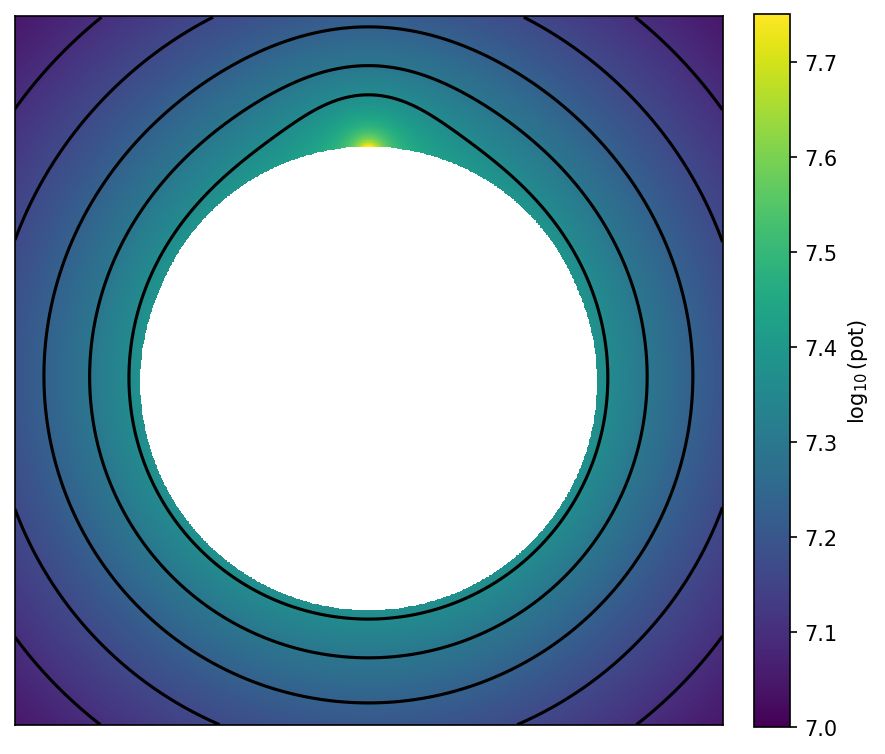

In [17]:
if mapa is not None:
    # Plot the potential, with pcolormesh
    fig, ax = plt.subplots(figsize=(6,6), dpi=150)

    pcm = ax.pcolormesh(np.log10(copyvot.abs()), vmin=7.0, vmax=7.75)

    # ax.set_title("Potential")
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

    cbar = plt.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("$\log_{10}$(pot)")

    # Draw some contours
    ax.contour(np.log10(pivot["pot"].abs()),
               levels=np.linspace(7.1, 7.36, 5),
               colors="k")
    
    fig.tight_layout()

    plt.savefig("potential.png", bbox_inches="tight")

    plt.show()

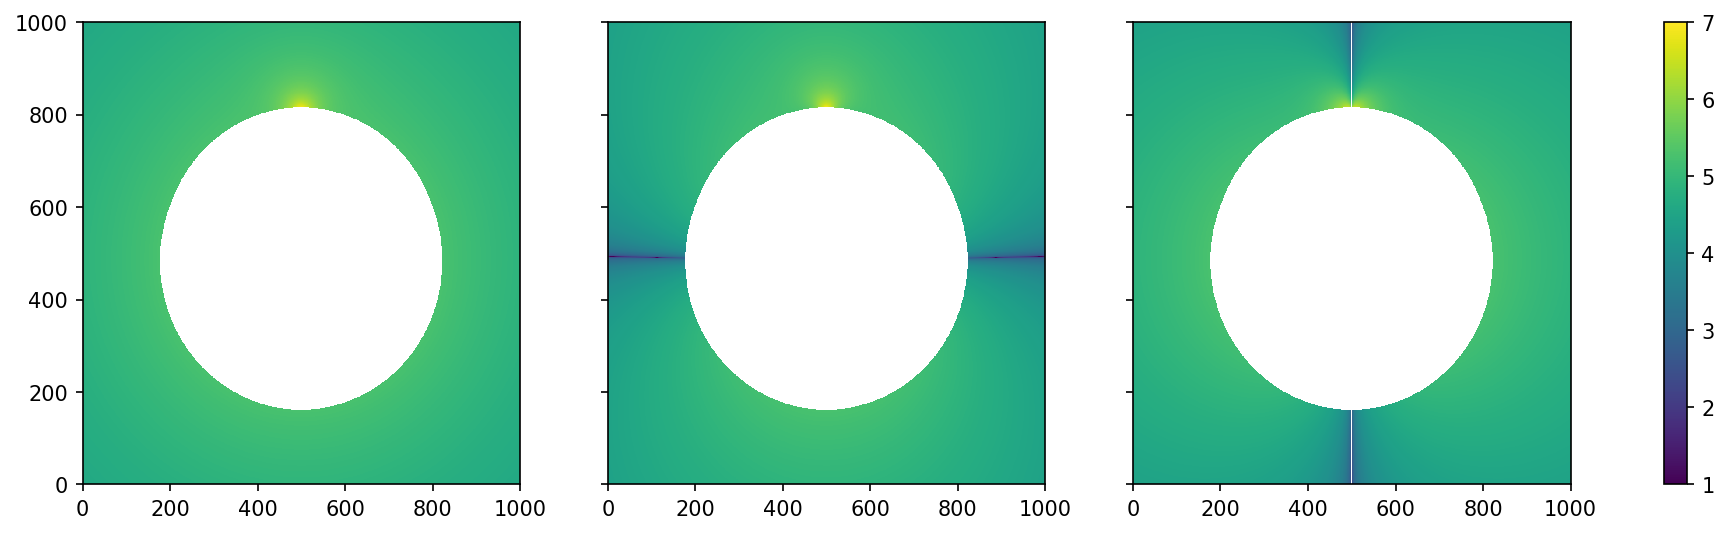

In [18]:
if mapa is not None:
    # Plot the potential, with pcolormesh
    fig, axs = plt.subplots(1,3,dpi=150, sharey=True, figsize=(16,4))
    axs[0].pcolormesh(np.log10(pivot["acc"].abs()), vmin=1, vmax=7)
    axs[1].pcolormesh(np.log10(pivot["ax"].abs()), vmin=1, vmax=7)
    p = axs[2].pcolormesh(np.log10(pivot["ay"].abs()), vmin=1, vmax=7)
    fig.colorbar(p, ax=axs.ravel().tolist())
    plt.show()